# PathFinding Data PreProcessing
* find subject data
* find experiment and eyetracking files
* combine experiment files for single subject to consolidate
* combine eyetracking files for single subject and pre-process
* performance analysis of PathFinding experiments

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [3]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Writing graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [25]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
import time

In [12]:
OG_DATA_PATH = './'

condition = 'Single' # Single, Dyadic, SingleC
DATA_PATH = './Data {}/'.format(condition)
RESSOURCES_PATH = './Ressources/'
#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')

PROCESSED_DATA_PATH = './Results/' + condition + '/'
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# Extracting all subject IDs from the data folder
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)

subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)


#subIDs = [1023] # remove to do for all subIDs
print(subIDs)

[1004 1005 1008 1010 1011 1013 1017 1018 1019 1021 1022 1023 1054 1055
 1056 1057 1058 1068 1069 1072 1073 1074 1075 1077 1079 1080]


# Combining Pathfinding Experiment Files per Subject

In [24]:
EXPT_FILE_ATTRS = ['ParticipantID', 'PathsReversed', 'IsDyadic', 'IsLeader'];


def map_dict(a_dictionary):
    a_subset = {key: value for key, value in a_dictionary.items() if key in EYE_FILE_ATTRS};
    return a_subset;

# For each subject in subject ID folder, combine all experiment files
# and save as a unified final experiment file in Result folder
for sub in subIDs:
    # Get all files for subject
    SUB_FILES = list(filter(lambda x: str(sub)+"_" in x, DATA_FOLDER));
    # Sort files into experiment files and eyetracking files
    EYETRACKING_FILES = list(filter(lambda x: 'EyeTracking' in x, SUB_FILES));
    EYETRACKING_FILES.sort();
    
    EXPT_FILES = list(filter(lambda x: condition + 'PathFinding' in x, SUB_FILES));
    EXPT_FILES.sort();
    
    EXPT_DATA = {};
        
    # For each experiment file
    for expt_file in EXPT_FILES:
        
        # Read JSON data
        with open(DATA_PATH + expt_file) as f:
            try:
                subject_session = json.loads(f.read())
            except:
                print("\tJSON file " + expt_file + " is not valid!")
                continue;
        
        # If there are more than one experiment files, combine the data of the paths if the 
        # other trial and subject information matches
        if len(EXPT_DATA) > 0:
            print([subject_session[x] for x in EXPT_FILE_ATTRS]);
            print([EXPT_DATA[x] for x in EXPT_FILE_ATTRS]);
            if(not all([subject_session[x] == EXPT_DATA[x] for x in EXPT_FILE_ATTRS])):
                raise Exception("Experiment File Data " + expt_file + " Does Not Match!")
            else:
                EXPT_DATA['Concatenated'] = True;
                EXPT_DATA['TrialData'] += subject_session['TrialData'];
        
        else:
            EXPT_DATA = subject_session;
            EXPT_DATA['Concatenated'] = False;
        
    # Check if correct number of paths present in experiment file
    if len(EXPT_DATA['TrialData']) != 10:
        raise Exception("Incorrent number of paths in file for Subject " + str(sub));
        break;
        
    # Save the final combined file in results to be accessed by eyetracking collection script
    expt_file_name = PROCESSED_DATA_PATH + str(sub) + "_"+condition+"Pathfinding_Final.json";
    with open(expt_file_name, 'w') as fp:
        json.dump(EXPT_DATA, fp);
    EXPT_DATA = {};
    

In [14]:
import random


# Store Time limits for each path condition
path_time_limits_A = [300, 305, 234, 332, 268, 394, 152, 383, 332];
path_time_limits_B = path_time_limits_A.copy();
path_time_limits_B.reverse();


# Leader : follower map
dyadic_pair_map = {
    '1021' : '1022',
    '1023' : '1013',
    '1005' : '1055',
    '1074' : '1069',
    '1008' : '1058',
    '1054' : '1004',
    '1011' : '1017',
    '1018' : '1057'
}

# Generate random session IDs to group leader and follower from same session easily in analysis
dyadic_session_ids = {}
for leader in dyadic_pair_map.keys():
    _id = random.randint(1000,9999);
    dyadic_session_ids[leader] = _id;
    dyadic_session_ids[dyadic_pair_map[leader]] = _id;
    
print(dyadic_session_ids);

{'1021': 4279, '1022': 4279, '1023': 8920, '1013': 8920, '1005': 4900, '1055': 4900, '1074': 2217, '1069': 2217, '1008': 5266, '1058': 5266, '1054': 3210, '1004': 3210, '1011': 8776, '1017': 8776, '1018': 3695, '1057': 3695}


### Combine the eyetracking data
* Loop through all subjects
* extract the session data
* combine the data
* save it

In [7]:
# --------- Preparation ---------

Session_save_bool = False # set to True if you want to save each individual session as csv
Exploration_save_bool = True # set to True if you want to save the complete exploration as csv#
Subject_Info_save_bool = True # set to True if you want to save the subject data as csv

subcount = 0
graffity_replaced_count = 0
removed_body_hits = 0
removed_nohouse_hits = 0

landmarks = ['Castle-TaskBuilding_56',
             'Church-TaskBuilding_16',
             'HighSilo-TaskBuilding_49',
             'Windmill-TaskBuilding_10_1',
             'crane_1',
             'crane_2']

garages_to_stay = ['Garage_185', 
                   'Garage_224', 
                   'Garage_235',  
                   'Garage_86', 
                   'Garage_98']

# column name list for dataframe
col_names =  ['PathNumber',
          'timeStampDataPointStart',
          'timeStampDataPointEnd',
          'serverTimeStampDataPointStart',
          'serverTimeStampDataPointEnd',
          'hitObjectColliderName', 
              'ordinalOfHit',
              'BitMask',
              'hitPointOnObject.x',
              'hitPointOnObject.y',
              'hitPointOnObject.z',
              'hitObjectColliderBoundsCenter.x',
              'hitObjectColliderBoundsCenter.y',
              'hitObjectColliderBoundsCenter.z',
              'transformed_collidercenter_x',
              'transformed_collidercenter_y'
              'hmdPosition.x',
              'hmdPosition.y',
              'hmdPosition.z']


# TODO: Add server times to nohitdict
NoHit_dict = {'hitObjectColliderName': 'NoHit',
              'ordinalOfHit': '1'}

# Remove machine time stamps if single
if 'Single' in condition:
    col_names.pop(3);
    col_names.pop(3);

subject_cols = ['SubjectID',
                'Total Rows Combined',
                'Removed Body Hits', 
                'Removed Graffiti Hits', 
                'Replaced NoHouse Hits',
                'DataLoss BitMask', 
                'DataLoss NoHits',
                'DataLoss Combined']

subject_data_df = pd.DataFrame(columns=subject_cols)


# --------------------------- MAIN PART ---------------------------


# --------- first layer - subject loop ---------

for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # Create empty dataframe for later concatenation
    complete_exploration_df = pd.DataFrame(columns = col_names)
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in DATA_FOLDER 
                             if f.startswith(str(subject)+'_EyeTrackingData_')], 
                            key=str.lower) 
    
    # the following works as long as the data name format is as follows:
    # 'subjectID'_Expl_S_'SessionNumber'_ET_'EyeTrackingSessionNumber'_'UnixTimestamp'.json
    folder_files = list()
       
    # loop through the subject folder and save all numbers
    for file in subject_folder:
        folder_files.append(re.findall(r'\d+', file))
    
    if len(folder_files) == 0:
        # raise Exception("No eyetracking files in " + condition +" condition for subject " + str(subject))
        print("No eyetracking files in " + condition +" condition for subject " + str(subject) +". Skipping.")
        continue;
    # Extract all SubIDs (only one), (and Timestamps)
    SubID, UnixTimestamp1, _ = map(list, zip(*folder_files))
    
    # Get the experiment JSON file for the subject
    sub_expt_data = {}
    sub_expt_file_name = PROCESSED_DATA_PATH + str(subject) + "_"+condition+"Pathfinding_Final.json";
    try:
        with open(sub_expt_file_name, 'r') as fp:
            sub_expt_data = json.load(fp);
    except:
        raise Exception("Could not read experiment file for subject " + str(subject));
    
# --------- second layer - path loop ---------
    s = 0;
    complete_hitpoints_df = pd.DataFrame(columns = col_names)
    previous_path_num = -1.0;
    # loop over separate eye tracking sessions
    for path_session in subject_folder:
        s+=1
        #print("\tSession " + str(s) + " started")

            # open the JSON file as dictionary
        with open(DATA_PATH + path_session) as f:
            try:
                subject_session = json.loads(f.read())
            except:
                print("\tJSON file " + path_session + " is not valid!")

        hitpoint_list = list() # create hitpoint list
        
        # check if trial is valid:
        trial_valid = subject_session['trials'][0]['trialIsValid']
        if not trial_valid:
            raise Exception("Excluding " + path_Session + " because trial is not valid!");
            continue;
        
        sub_id = subject_session['trials'][0]['participantId']
        if str(sub_id) != str(subject):
            raise Exception("Excluding " + path_Session + " because subject IDs don't match!");
            continue;
        
        # start timestamp of the session 
        start_time = subject_session['trials'][0]['timeTrialMeasurementStarted']
        
        # get trial id (path number)
        path_num = subject_session['trials'][0]['trialId']
        
        expt_path_start_time = sub_expt_data['TrialData'][path_num]['StartMachineTimeStamp'];
        expt_path_end_time = sub_expt_data['TrialData'][path_num]['EndMachineTimeStamp'];
        
        machine_time_stamp_diff = 0.0;
        if 'Single' not in condition and path_num != previous_path_num:
            expt_path_start_srvtime_mS = sub_expt_data['TrialData'][path_num]['StartServerTimeStamp'];
            machine_time_stamp_diff = expt_path_start_time - expt_path_start_srvtime_mS / 1000;
            previous_path_num = path_num;

        # amount of datapoints 
        Len_subses = len(subject_session['trials'][0]['dataPoints'])

        # for loop appending each data point rayCastHit Data
        # afterwards adding the timestamp to the dict 
        # if there is (1) no raycast hit appending NoHit Dict

        # --------------- First order hits! ---------------
        for each in subject_session['trials'][0]['dataPoints']:

            # account for noHits 
            if each['rayCastHitsCombinedEyes'] == []:
                hitpoint_list.append(NoHit_dict)
                # set index for new entry
                idx = len(hitpoint_list)-1
                hitpoint_list[idx]['PathNumber'] = path_num
                hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                # hmdPosition
                hitpoint_list[idx]['hmdPosition.x'] = each['hmdPosition']['x']
                hitpoint_list[idx]['hmdPosition.y'] = each['hmdPosition']['y']
                hitpoint_list[idx]['hmdPosition.z'] = each['hmdPosition']['z']
            else:
                # append data point
                hitpoint_list.append(each['rayCastHitsCombinedEyes'][0]) 
                # add path number, timestamp and bitmask
                idx = len(hitpoint_list)-1
                hitpoint_list[idx]['PathNumber'] = path_num
                
                current_collider = hitpoint_list[idx]['hitObjectColliderName']
                
                # Exclude the data point if it lies outside of the times for a path
                # TODO: Should this be excluded? Perhaps do a per-subject-analysis of how many points
                #           would end up excluded?
                if each['timeStampDataPointStart'] < expt_path_start_time or each['timeStampDataPointStart'] > expt_path_end_time:
                    hitpoint_list[idx]['PathNumber'] += 0; # Change this to some other high number to exclude


                # Add the server time stamp if dyadic
                if 'Single' not in condition:
                    hitpoint_list[idx]['serverTimeStampDataPointStart'] = (each['timeStampDataPointStart'] - machine_time_stamp_diff) * 1000.0;
                    hitpoint_list[idx]['serverTimeStampDataPointEnd'] = (each['timeStampDataPointEnd'] - machine_time_stamp_diff) * 1000.0;
                hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                
                # Add HMD position
                hitpoint_list[idx]['hmdPosition'] = each['hmdPosition'];
                # ----- CONDITIONS FOR CLEANING -----
                        
                # ----- Merging obsolete colliders -----
                if current_collider in list(houselist.source_collider_name):

                    collider_data = houselist[houselist.source_collider_name==current_collider]


                    hitpoint_list[idx]['hitObjectColliderName'] = \
                        collider_data.target_collider_name.values[0]

                    # change collider coordinates
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                        collider_data['ColliderBoundsCenter.x'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                        collider_data['ColliderBoundsCenter.y'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                        collider_data['ColliderBoundsCenter.z'].values[0]    
                    hitpoint_list[idx]['transformed_collidercenter_x'] = \
                        collider_data['transformed_collidercenter_x'].values[0]
                    hitpoint_list[idx]['transformed_collidercenter_y'] = \
                        collider_data['transformed_collidercenter_y'].values[0]

                # ----- NoHouse Hits -----
                # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                elif current_collider not in list(houselist.source_collider_name) \
                and current_collider != 'Body' \
                and (current_collider.startswith('Graffity_')) == False:
                    hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'

                # QUESTION: What's happening here?
                else:
                    try:
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                            collider_data['ColliderBoundsCenter.x'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                            collider_data['ColliderBoundsCenter.y'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                            collider_data['ColliderBoundsCenter.z'].values[0]   
                        hitpoint_list[idx]['transformed_collidercenter_x'] = \
                            collider_data['transformed_collidercenter_x'].values[0]
                        hitpoint_list[idx]['transformed_collidercenter_y'] = \
                            collider_data['transformed_collidercenter_y'].values[0]
                    except:
                        pass

            # --------------- Second order hits! ---------------
            try: 
                # append data point of second raycast hit if it exists
                hitpoint_list.append(each['rayCastHitsCombinedEyes'][1])
                # add Path number, timestamp and bitmask
                idx = len(hitpoint_list)-1
                hitpoint_list[idx]['PathNumber'] = hitpoint_list[idx-1]['PathNumber'];
                
                # Add the server time stamp if dyadic
                if 'Single' not in condition:
                    hitpoint_list[idx]['serverTimeStampDataPointStart'] = (each['timeStampDataPointStart'] - machine_time_stamp_diff) * 1000.0;
                    hitpoint_list[idx]['serverTimeStampDataPointEnd'] = (each['timeStampDataPointEnd'] - machine_time_stamp_diff) * 1000.0;
                
                hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                
                # ----- Merging obsolete colliders -----
                if current_collider in list(houselist.source_collider_name):

                    collider_data = houselist[houselist.source_collider_name==current_collider]


                    hitpoint_list[idx]['hitObjectColliderName'] = \
                        collider_data.target_collider_name.values[0]

                    # change collider coordinates
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                        collider_data['ColliderBoundsCenter.x'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                        collider_data['ColliderBoundsCenter.y'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                        collider_data['ColliderBoundsCenter.z'].values[0]    
                    hitpoint_list[idx]['transformed_collidercenter_x'] = \
                        collider_data['transformed_collidercenter_x'].values[0]
                    hitpoint_list[idx]['transformed_collidercenter_y'] = \
                        collider_data['transformed_collidercenter_y'].values[0]

                # ----- NoHouse Hits -----
                # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                elif current_collider not in list(houselist.source_collider_name) \
                and current_collider != 'Body' \
                and (current_collider.startswith('Graffity_')) == False:
                    hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'

                else:
                    try:
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                            collider_data['ColliderBoundsCenter.x'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                            collider_data['ColliderBoundsCenter.y'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                            collider_data['ColliderBoundsCenter.z'].values[0]   
                        hitpoint_list[idx]['transformed_collidercenter_x'] = \
                            collider_data['transformed_collidercenter_x'].values[0]
                        hitpoint_list[idx]['transformed_collidercenter_y'] = \
                            collider_data['transformed_collidercenter_y'].values[0]
                    except:
                        pass
                
                # if the first order hit was a NoHouse hit, but the second was not
                if hitpoint_list[idx-1]['hitObjectColliderName'] == 'NoHouse' \
                and hitpoint_list[idx]['hitObjectColliderName'] != 'NoHouse':
                    removed_nohouse_hits += 1

                    hitpoint_list[idx]['ordinalOfHit'] = 1


                    # and remove the first order hit
                    del hitpoint_list[idx-1]

                    idx -= 1 # reset index for safety
                # ----- Body Hits -----
                # check if there is a 1 order Body hit, if yes: replace it with second order hit
                elif hitpoint_list[idx-1]['hitObjectColliderName'] == 'Body':
                    # if second order hit is not a body hit, replace first order hit
                    if hitpoint_list[idx]['hitObjectColliderName'] != 'Body':
                        removed_body_hits += 1

                        hitpoint_list[idx]['ordinalOfHit'] = 1 


                        # and remove the second order hit
                        del hitpoint_list[idx-1]
                        idx -= 1 # reset index for safety

                    # if second order hit is a body hit, replace first order hit with NoHit
                    else:
                        removed_body_hits += 1

                        # replace the first order hit data
                        hitpoint_list[idx-1]['hitObjectColliderName'] = 'NoHit'
                        hitpoint_list[idx-1]['hitPointOnObject.x'] = 'NaN'
                        hitpoint_list[idx-1]['hitPointOnObject.y'] = 'NaN'
                        hitpoint_list[idx-1]['hitPointOnObject.z'] = 'NaN'
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                        hitpoint_list[idx-1]['transformed_collidercenter_x'] = 'NaN'
                        hitpoint_list[idx-1]['transformed_collidercenter_y'] = 'NaN'

                        # and remove the second order hit
                        del hitpoint_list[idx]

            except:
                pass
        
        # REMOVING REMAINING GRAFFITY AND BODY HITS
        for index in range(len(hitpoint_list)):
            if hitpoint_list[index]['hitObjectColliderName'] == 'Body':
                removed_body_hits += 1
                hitpoint_list[index]['hitObjectColliderName'] = 'NoHit'
                hitpoint_list[index]['hitPointOnObject.x'] = 'NaN'
                hitpoint_list[index]['hitPointOnObject.y'] = 'NaN'
                hitpoint_list[index]['hitPointOnObject.z'] = 'NaN'
                hitpoint_list[index]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                hitpoint_list[index]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                hitpoint_list[index]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                hitpoint_list[index]['transformed_collidercenter_x'] = 'NaN'
                hitpoint_list[index]['transformed_collidercenter_y'] = 'NaN'

            # check if there are Graffity Hits and rename them as the building they are on
            if hitpoint_list[index]['hitObjectColliderName'].startswith('Graffity_'):
                building_number = re.search(r'\d+', hitpoint_list[index]['hitObjectColliderName']).group()
                graffity_to_building = []


                # if the number is between 0 and 9, remove the 0
                building_number = str(int(building_number))

                for house in list(houselist.target_collider_name):
                    #check if the exact building number is in the houselist to replace graffity name
                    # additionally check that it's not a landmark or a garage to stay
                    if house.endswith('_' + building_number) \
                    and house not in landmarks \
                    and house not in garages_to_stay:
                        # check if the house name is already in the list
                        if house in graffity_to_building:
                            pass
                        else:
                            graffity_to_building.append(house)

                if len(graffity_to_building) == 1:
                    hitpoint_list[index]['hitObjectColliderName'] = graffity_to_building[0]
                    graffity_replaced_count += 1
                else:
                    print('Multiple houses with the same number! - Index: ' 
                          + str(index)
                          + ', ' 
                          + str(graffity_to_building))
                    
        # normalize the hitpoint dictionary to get dataframe
        hitpoints_df = pd.json_normalize(hitpoint_list)

        print("\tET: " + str(s) + " normalized")

        complete_hitpoints_df = complete_hitpoints_df.append(hitpoints_df)


    # --------- Saving each Session ---------

    # If you want to save each session separately, set 'Session_save_bool' to True
    if Session_save_bool == True:
        try:
            if len(subject_data) > 0:
                complete_hitpoints_df.to_csv(PROCESSED_DATA_PATH
                                             + str(subject)
                                             + "_" + condition
                                             + "_CompleteHitpoints.csv")
                print("\t"
                      + str(subject)
                      + " session "
                      + "_" + condition
                      + " saved ")
            else: 
                print("\t"
                      + str(subject)
                      + " - Session "
                      + "_" + condition
                      + " is empty!")
        except:
            print("\tCould not save subject "
                  + str(subject)
                  + " session "
                  + "_" + condition
                  + "!")



    # fill the complete exploration dataframe with the separate session data (combining the sessions)
    complete_exploration_df = complete_exploration_df.append(complete_hitpoints_df)
        
    # --------- Saving the Exploration ---------
    
    # If you want to save the exploration file, set 'Exploration_save_bool' to True
    if Exploration_save_bool == True:
        # saving the complete exploration
        try:
            complete_exploration_df.to_csv(PROCESSED_DATA_PATH + str(subject) + "_" + condition + "_CompleteHitpoints.csv")
            print("\t" + str(subject) + " " + condition + " eyetracking data saved")
        except:
            print("\tCould not save subject " + str(subject) + " " + condition + " eyetracking data!")
    
    print("\t" + str(subject) + " - Stats: ")
    print("\tRemoved Body Hits: " 
          + str(removed_body_hits) 
          + ' Removed Graffities: ' 
          + str(graffity_replaced_count) 
          + ' Replaced 1st NoHouse hits: ' 
          + str(removed_nohouse_hits))


    # Some information about the data
    bit_prop = np.sum(complete_exploration_df['BitMask'] != 3) \
        / len(complete_exploration_df)
    noHit_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHit') \
        / len(complete_exploration_df)
    noHouse_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHouse') \
        / len(complete_exploration_df)

    print("\tPortion of insufficient data quality (BitMask): " 
          + str("{:.2f}".format(100*bit_prop)) 
          + '%') 
    print("\tNoHits: " 
          + str("{:.2f}".format(100*noHit_prop)) 
          + '%')
    print("\tNoHouse: " 
          + str("{:.2f}".format(100*noHouse_prop)) 
          + '%')
    print("\tTotal missing data: " 
          + str("{:.2f}".format(100*(bit_prop + noHit_prop))) 
          + '%') 


    # fill the subject info dataframe
    subject_data_df.loc[subcount-1, 'SubjectID'] = subject
    subject_data_df.loc[subcount-1, 'Total Rows Combined'] = len(complete_exploration_df)
    subject_data_df.loc[subcount-1, 'Removed Body Hits'] = removed_body_hits
    subject_data_df.loc[subcount-1, 'Removed Graffiti Hits'] = graffity_replaced_count
    subject_data_df.loc[subcount-1, 'Replaced NoHouse Hits'] = removed_nohouse_hits
    subject_data_df.loc[subcount-1, 'DataLoss BitMask'] = bit_prop
    subject_data_df.loc[subcount-1, 'DataLoss NoHits'] = noHit_prop
    subject_data_df.loc[subcount-1, 'DataLoss Combined'] = bit_prop + noHit_prop

if Subject_Info_save_bool == True:
    try:
        subject_data_df.to_csv(PROCESSED_DATA_PATH
                                       + "Subject_Data.csv", 
                                        index=False)

        print("Subject Data saved")
    except:
        print("Could not save subject data!")
print('Done')

Subject 1004 started - 1/26
No eyetracking files in Single condition for subject 1004. Skipping.
Subject 1005 started - 2/26
No eyetracking files in Single condition for subject 1005. Skipping.
Subject 1008 started - 3/26
No eyetracking files in Single condition for subject 1008. Skipping.
Subject 1010 started - 4/26
No eyetracking files in Single condition for subject 1010. Skipping.
Subject 1011 started - 5/26
No eyetracking files in Single condition for subject 1011. Skipping.
Subject 1013 started - 6/26
No eyetracking files in Single condition for subject 1013. Skipping.
Subject 1017 started - 7/26
No eyetracking files in Single condition for subject 1017. Skipping.
Subject 1018 started - 8/26
No eyetracking files in Single condition for subject 1018. Skipping.
Subject 1019 started - 9/26
No eyetracking files in Single condition for subject 1019. Skipping.
Subject 1021 started - 10/26
No eyetracking files in Single condition for subject 1021. Skipping.
Subject 1022 started - 11/26


In [9]:
Result_df = pd.read_csv(PROCESSED_DATA_PATH+'1023_Single_CompleteHitpoints.csv')

In [10]:
Result_df

,Unnamed: 0,PathNumber,timeStampDataPointStart,timeStampDataPointEnd,hitObjectColliderName,ordinalOfHit,BitMask,hitPointOnObject.x,hitPointOnObject.y,hitPointOnObject.z,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z,transformed_collidercenter_x,transformed_collidercenter_yhmdPosition.x,hmdPosition.y,hmdPosition.z,hmdPosition.x,transformed_collidercenter_y
0,0,0,0.001984,0.007936,NoHouse,1,3,251.315308,-0.877272,170.721466,251.851456,-2.287690,171.080597,NaN,NaN,-0.494329,170.390976,250.958450,NaN
1,1,0,0.001984,0.007936,NoHouse,2,3,252.663849,-2.399850,172.152802,39.257874,-4.408301,51.768860,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0.008432,0.008432,NoHouse,1,3,251.315308,-0.877272,170.721466,251.851456,-2.287690,171.080597,NaN,NaN,-0.494329,170.390976,250.958450,NaN
3,3,0,0.008432,0.008432,NoHouse,2,3,252.663849,-2.399850,172.152802,39.257874,-4.408301,51.768860,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,0.011904,0.014880,NoHouse,1,3,252.691284,-2.400710,172.184113,39.257874,-4.408301,51.768860,NaN,NaN,-0.494738,170.429337,250.988846,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245293,18413,9,90.206415,90.206415,NoHouse,2,3,-282.912537,-0.626187,-180.557816,-491.456299,18.698456,-597.844604,NaN,NaN,NaN,NaN,NaN,NaN
245294,18414,9,90.225760,90.228735,NoHouse,1,3,-282.881683,-0.488985,-180.404495,-217.756897,-2.905127,-288.595245,NaN,NaN,1.367091,-177.778519,-282.382690,NaN
245295,18415,9,90.225760,90.228735,NoHouse,2,3,-282.919189,-0.627347,-180.598740,-491.456299,18.698456,-597.844604,NaN,NaN,NaN,NaN,NaN,NaN
245296,18416,9,90.228735,90.228735,NoHouse,1,3,-282.881683,-0.488985,-180.404495,-217.756897,-2.905127,-288.595245,NaN,NaN,1.367091,-177.778519,-282.382690,NaN


In [11]:
print("data points excluded for 1023: ");
(Result_df['PathNumber'] > 20).value_counts()


data points excluded for 1023: 


False    245298
Name: PathNumber, dtype: int64

### Condense the data and create gaze lists
* Do Runlength Encoding on the colliderName column to reduce the data size

### Interpolation of the data to minimize cut clustering (based on Walter, 2021)
* Interpolation criteria:
    * there are <=21 consecutive NoHit Samples
    * they are surrounded by two clusters on the same collider

In [18]:
# --------- Preparation ---------
RLE_save_bool = False # if you want to save the condensed dataframe
Interpolation_save_bool = True # if you want to save the condensed dataframe
Subject_Info_save_bool = True # set to True if you want to save the subject data as csv

# column names for the condensed df
condense_col_names = ['Session', 
                      'ColliderName',
                      'Samples',]

# column names for the interpolation df
interpol_col_names = ['ColliderName',
                      'Samples',
                      'Index']

subcount = 0 # count subjects


# open the subject data csv
with open(PROCESSED_DATA_PATH + "Subject_Data.csv") as f:
    try:
        subject_data_df = pd.read_csv(f)
    except:
        print("Subject Data file could not be loaded!")



# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_'+condition +'_CompleteHitpoints')], key=str.lower)
    
    if len(subject_folder) != 0:
    
        # open the JSON file as dictionary
        with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
            try:
                data = pd.read_csv(f)
            except:
                print("\tCSV file " + subject_folder[0] + " is not valid!")
    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 
           
    data = data[data.ordinalOfHit==1]
    data.reset_index(inplace=True, drop=False)
    
    
    
    # --------- CONDENSE PART ---------
    # dataframe for counting successive appearances
    condense_df = pd.DataFrame(index=range(len(data)), columns=condense_col_names)
    condense_df.ColliderName = data.hitObjectColliderName
    # count successive appearances by comparing with shifted df + cumsum + cumcount
    condense_df['Samples'] = \
    data['hitObjectColliderName'].groupby((data['hitObjectColliderName'] 
                                           != data['hitObjectColliderName'].shift()).cumsum()).cumcount() + 1

    
    # use the condense_df to sum up unique countings
    condense_count = (data['hitObjectColliderName'] != data['hitObjectColliderName'].shift()).cumsum()
    ColliderNames_df = pd.DataFrame()
    Samples_df = pd.DataFrame()

    # find the respective collidername by searching for the first (and possibly only) appearance
    ColliderNames_df['ColliderName'] = condense_df[condense_df.Samples==1].ColliderName
    ColliderNames_df.reset_index(inplace=True, drop=True)
    # count the actual successive appearances by grouping by the unique countings in condense_count
    Samples_df['Samples'] = condense_df.groupby(condense_count).ColliderName.count()
    Samples_df.reset_index(inplace=True, drop=True)

    
    # join the Dataframes 
    condense_RLE_df = ColliderNames_df.join(Samples_df)
    print(len(condense_RLE_df))
    print(len(data))
    
    # --------- INTERPOLATION PART ---------
    condense_data = condense_RLE_df.copy() #copy for safety
    
    current_collider = 'X' # the reference collidername for interpolation
    last_hits = 0 # the reference hit sum for interpolation 
    
    interpolated_data = pd.DataFrame(columns=interpol_col_names) # create empty df for interpolation
    
    # loop through the condense dataframe and search for the following conditions:
    # 1. ColliderName is 'NoHit' and the Sample Size is <=21: add the sample size to the sample variable
    # 2. ColliderName is 'NoHit' and the Sample Size is >21: append the NoHit Row to the new Interpolation df
    # 3. ColliderName is NOT the current collider: append the Row to the new Interpolation df 
    #    and set to current collider
    # 4. ColliderName IS the current collider: add the sample size to the collider row in the interpolation df
    
    for index, collider in enumerate(condense_data.ColliderName):
        print("\tInterpolation Status: " + str("{:.1f}".format(100*index/len(condense_data))) + '%', end="\r")

        if collider == 'NoHit': # we need to check also for the current collidername 
            if condense_data.Samples[index] <= 21:
                last_hits += condense_data.Samples[index]
            else:
                interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
                interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
                last_hits = 0
                current_collider = 'X'

        elif collider != current_collider:
            if last_hits > 0:
                interpolated_data = interpolated_data.append({'ColliderName': 'NoHit',\
                                                              'Samples': last_hits,\
                                                              'Index': index-1}, \
                                                              ignore_index=True)
                
                
            interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
            interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
            last_hits = 0
            current_collider = condense_data.ColliderName[index]
        else:
            interpolated_data.loc[len(interpolated_data)-1, 'Samples'] += last_hits + condense_data.Samples[index]
            last_hits = 0

    
    removed_hits = len(condense_data) - len(interpolated_data)
    prop = removed_hits/len(condense_data)
    
    
    if removed_hits != len(condense_data):
        print("\tInterpolation successful! - Removed rows: " 
              + str(removed_hits) 
              + ', ' 
              + str("{:.1f}".format(100*prop))
              + '%')
    else:
        print('Something went wrong with the interpolation')
    
    
    
    # --------- SAVING ---------
    # If you want to save the exploration file, set 'RLE_save_bool' to True
    if RLE_save_bool == True:
        # saving the condensed dataframe
        try:
            condense_RLE_df.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_condense_RLE_df.csv", 
                                            index=False)
            
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " condensed dataframe!")
            
    if Interpolation_save_bool == True:
        # saving the interpolation dataframe
        try:
            interpolated_data.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_interpolation_df.csv", 
                                            index=False)
            
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " interpolation dataframe!")

       
    # fill the subject data df
    sub_loc = subject_data_df[subject_data_df['SubjectID'] == subject].index[0]
    subject_data_df.loc[sub_loc, "Condensed Size"] = len(interpolated_data)
    subject_data_df.loc[sub_loc, "Removed rows"] = removed_hits
    subject_data_df.loc[sub_loc, "Removed rows (%)"] = prop
    


            
if Subject_Info_save_bool == True:
    # saving the subject info dataframe            
    

    try:
        subject_data_df.to_csv(PROCESSED_DATA_PATH
                                       + "Subject_Data.csv", 
                                        index=False)

        print("Subject Info dataframe saved")
    except:
        print("\tCould not save subject " + str(subject) + " interpolation dataframe!")
        
    
    

print('Done')

Subject 1004 started - 1/26
Subject 1004 has no data file!
Subject 1005 started - 2/26
Subject 1005 has no data file!
Subject 1008 started - 3/26
Subject 1008 has no data file!
Subject 1010 started - 4/26
Subject 1010 has no data file!
Subject 1011 started - 5/26
Subject 1011 has no data file!
Subject 1013 started - 6/26
Subject 1013 has no data file!
Subject 1017 started - 7/26
Subject 1017 has no data file!
Subject 1018 started - 8/26
Subject 1018 has no data file!
Subject 1019 started - 9/26
Subject 1019 has no data file!
Subject 1021 started - 10/26
Subject 1021 has no data file!
Subject 1022 started - 11/26
Subject 1022 has no data file!
Subject 1023 started - 12/26
7031
133671
	Interpolation successful! - Removed rows: 210, 3.0%
	1023 dataframe saved
Subject 1054 started - 13/26
Subject 1054 has no data file!
Subject 1055 started - 14/26
Subject 1055 has no data file!
Subject 1056 started - 15/26
Subject 1056 has no data file!
Subject 1057 started - 16/26
Subject 1057 has no data

### Raw Subject Stats


In [19]:
with open(PROCESSED_DATA_PATH + 'Subject_Data.csv') as f:
    try:
        subject_data_df = pd.read_csv(f)
    except:
            print("\tCould not load subject data!")
            

mean_rows = round(np.mean(subject_data_df["Total Rows Combined"]),2)
std_rows = round(np.std(subject_data_df["Total Rows Combined"]),2)

mean_rows = round(np.mean(subject_data_df["Total Rows Combined"]),2)
std_rows = round(np.std(subject_data_df["Total Rows Combined"]),2)

mean_dataloss = round(100*np.mean(subject_data_df["DataLoss Combined"]),2)
std_dataloss = round(100*np.std(subject_data_df["DataLoss Combined"]),2)

mean_condensed_size = round(np.mean(subject_data_df["Condensed Size"]), 2)
std_condensed_size = round(np.std(subject_data_df["Condensed Size"]),2)

mean_removed_rows = round(np.mean(subject_data_df["Removed rows"]),2)
std_removed_rows = round(np.std(subject_data_df["Removed rows"]),2)

mean_removed_rows_per = round(100*np.mean(subject_data_df["Removed rows (%)"]),2)
std_removed_rows_per = round(100*np.std(subject_data_df["Removed rows (%)"]),2)

            
print('Mean/STD Total Rows: {}/{}'.format(mean_rows, std_rows))
print('Mean/STD DataLoss Combined: {}%/{}%'.format(mean_dataloss, std_dataloss))
print('Mean/STD Condensed Size and Removed Rows: {}/{} - {}/{}({}%/{}%)'.format(mean_condensed_size, \
                                                                                std_condensed_size, \
                                                                                mean_removed_rows, \
                                                                                std_removed_rows, \
                                                                                mean_removed_rows_per, \
                                                                                std_removed_rows_per))



Mean/STD Total Rows: 245298.0/0.0
Mean/STD DataLoss Combined: 4.12%/0.0%
Mean/STD Condensed Size and Removed Rows: 6821.0/0.0 - 210.0/0.0(2.99%/0.0%)


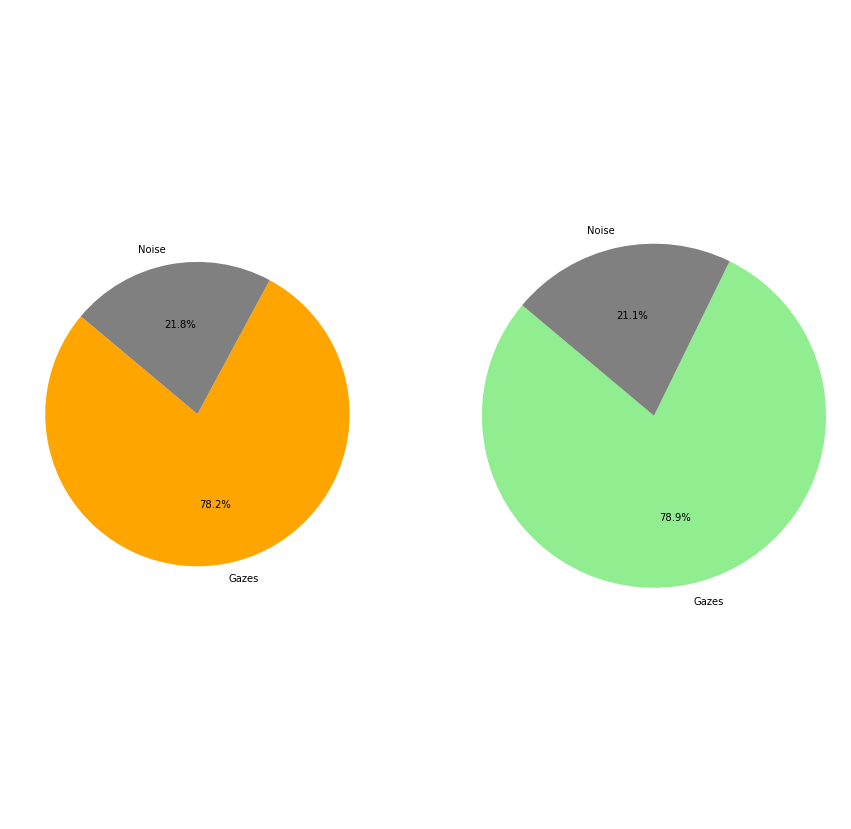

In [20]:
gazes = condense_RLE_df[condense_RLE_df.Samples>21].Samples.sum()
noise = condense_RLE_df[condense_RLE_df.Samples<21].Samples.sum()

gazes_interpolated = interpolated_data[interpolated_data.Samples>21].Samples.sum()
noise_interpolated = interpolated_data[interpolated_data.Samples<21].Samples.sum()



# Data to plot
labels = 'Gazes', 'Noise'
sizes = [gazes, noise]
colors = ['orange', 'gray']
explode = (0, 0, 0, 0)  # explode 1st slice

# Data to plot after interpolation
labels_interpolated = 'Gazes', 'Noise'
sizes_interpolated = [gazes_interpolated, noise_interpolated]
colors_interpolated = ['lightgreen', 'gray']
explode_interpolated = (0, 0, 0, 0)  # explode 1st slice


# Plot
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.subplot(1,2,2)
plt.pie(sizes_interpolated, labels=labels_interpolated, colors=colors_interpolated,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.axis('equal')
plt.show()

In [21]:
gazes_interpolated = interpolated_data[interpolated_data.Samples>21]

ColliderAppearances = gazes_interpolated.groupby('ColliderName').Samples.sum()

Colliders_onlyHouses = ColliderAppearances.copy()
Colliders_onlyHouses = Colliders_onlyHouses.drop(labels=['NoHouse'])
Colliders_onlyHouses = Colliders_onlyHouses.sort_values()




sorted_interpolation = interpolated_data.groupby('ColliderName').Samples.sum().sort_values()

building14distance = round((sorted_interpolation['TaskBuilding_14'] \
                            - sorted_interpolation[0:-1].mean()) \
                           / sorted_interpolation[0:-1].std(),2)

print('The most viewed building after interpolation is currently {} sigma away from the mean!'.format(building14distance))
ColliderAppearances.sort_values()[-16:-1]


The most viewed building after interpolation is currently 2.68 sigma away from the mean!


ColliderName
Building_233       408
NoHit              416
TaskBuilding_48    428
TaskBuilding_18    449
Building_142       477
TaskBuilding_29    490
TaskBuilding_14    493
TaskBuilding_39    505
TaskBuilding_41    546
TaskBuilding_46    556
TaskBuilding_11    564
Building_94        571
Building_145       573
TaskBuilding_1     668
Building_64        692
Name: Samples, dtype: int64

(array([0.15943117, 0.0310409 , 0.02404193, 0.01195279, 0.01517959,
        0.00668084, 0.00618091, 0.00609002, 0.00727166, 0.00377217,
        0.0033177 , 0.00286322, 0.00272687, 0.00240874, 0.00159068,
        0.00145433, 0.00145433, 0.00163612, 0.00136344, 0.00131799,
        0.00095441, 0.00099985, 0.00118164, 0.00063627, 0.00054537,
        0.00068172, 0.00068172, 0.00049993, 0.00049993, 0.00040903,
        0.01113473]),
 array([1.0, 4.225806451612903, 7.451612903225806, 10.677419354838708,
        13.903225806451612, 17.129032258064516, 20.354838709677416,
        23.58064516129032, 26.806451612903224, 30.032258064516128,
        33.25806451612903, 36.483870967741936, 39.70967741935483,
        42.93548387096774, 46.16129032258064, 49.387096774193544,
        52.61290322580645, 55.83870967741935, 59.064516129032256,
        62.29032258064516, 65.51612903225806, 68.74193548387096,
        71.96774193548387, 75.19354838709677, 78.41935483870967,
        81.64516129032258, 84.870967

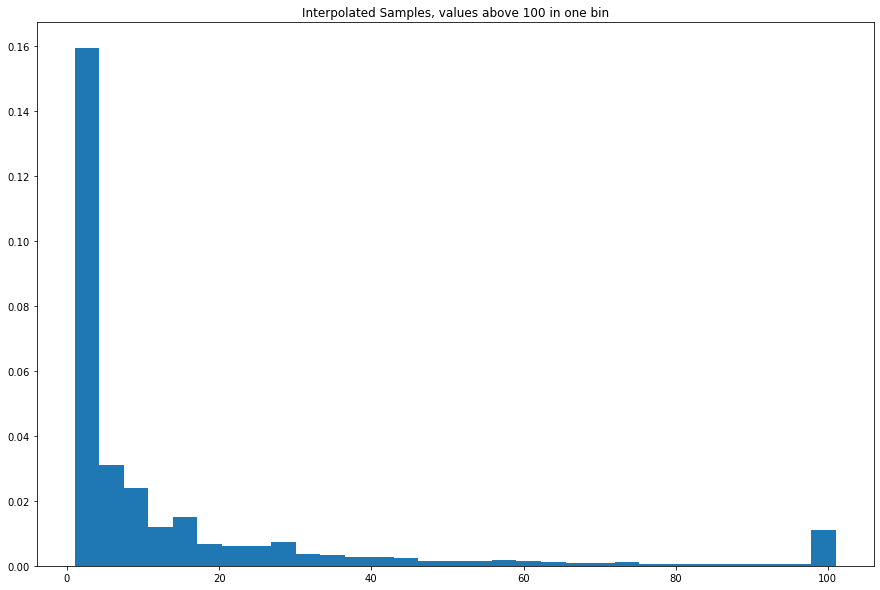

In [22]:
interpolation_til_100 = interpolated_data.copy()
interpolation_til_100 = interpolation_til_100.Samples
interpolation_til_100[interpolation_til_100>100] = 101

plt.figure(figsize=(15,10))
plt.title('Interpolated Samples, values above 100 in one bin')
plt.hist(interpolation_til_100, bins= 31, density=True)

## Graph Creation
* The graph creation involves the following steps:
    * creating the edge list
        * Remove non Fixations (SampleSize <= 21) 
        * Remove all noHouse hits 
        * Remove all noHit hits 
        * Remove all self repetitions
        * Shift the edgelist by one row and create chronology 
    * Use NetworkX to build the graph
    * Plot the graph onto the city map (using map coordinates)

In [26]:
# --------- Preparation ---------
Plotting_bool = False # if you want to plot the graph
EdgeList_save_bool = False # if you want to save the edge list 
Graph_save_bool = False # if you want to save the graph as a networkx graph
Graph_save_img_bool = False # if you want to save the graph as an image
plot_edges_bool = False # if you want to plot the graph's edges
save_centrality = True # if you want to save the centrality dataframe (node degree) as csv 

subcount = 0 # count subjects

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")

# Dataframe for degrees with colums = subject + houselist
centrality_df = pd.DataFrame(columns= [*['Subject'], *np.unique(houselist.target_collider_name)])



# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_interpolation_df')], key=str.lower)

    if len(subject_folder) != 0:
        
        # open the JSON file as dictionary
        with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
            try:
                interpolated_data = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " interpolation dataframe!")

    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 

    edge_list = pd.DataFrame(columns=['Edge1','Edge2'])



    # --------- EDGE LIST CREATION ---------

    # filter out Clusters with <=21 hits, 'NoHouse' hits, 'NoHit' hits and self repititions (with unique)
    transition = interpolated_data[interpolated_data.Samples>21]
    transition = transition[transition.ColliderName!='NoHouse']
    transition = transition[transition.ColliderName!='NoHit']
    unique_count = transition.ColliderName.groupby((transition['ColliderName'] 
                                            != transition['ColliderName'].shift()).cumsum()).cumcount() + 1

    # Assign filtered gaze hits to the edge list 
    edge_list.Edge1 = transition[unique_count==1].ColliderName
    edge_list.reset_index(inplace=True, drop=True)

    # shift the gaze hits by one and add the last entry of Edge1 to the first of Edge 2
    edge_list.Edge2[1:len(edge_list)-1] = edge_list.Edge1[0:len(edge_list)-2]
    edge_list.loc[0, 'Edge2'] = edge_list.Edge1[len(edge_list)-1]
    edge_list.loc[len(edge_list)-1, 'Edge2'] = edge_list.Edge1[0]

    # --------- GRAPH CREATION ---------

    # create graph from edgelist
    G = nx.Graph()
    G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')


    # Setting the node coordinates of each node of the graph


    # node list
    nodelist = list(G.nodes)

    # coord dict
    node_pos = {}

    for node in nodelist:
        # assign node coordinates
        x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
        y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
        node_pos[node] = (x,y) 

    # set the graph's node coordinates attribute
    nx.set_node_attributes(G, node_pos, 'coord')


    # --------- ANALYSIS ---------

    # create degree list of the graph 
    sub_degree = dict(list(G.degree))
    # add the subject ID to the dictionary
    sub_degree.update({'Subject': str(subject)})  
    # append the centrality df by the subjects degree list
    centrality_df = centrality_df.append(sub_degree, ignore_index=True)
    #centrality_df['betweenness'] = list(nx.betweenness_centrality(G))


    mean_degree = np.nanmean(pd.to_numeric(centrality_df[centrality_df.Subject==str(subject)].values[0])[1:])
    std_degree = np.nanstd(pd.to_numeric(centrality_df[centrality_df.Subject==str(subject)].values[0])[1:])
    max_degree = max(pd.to_numeric(centrality_df[centrality_df.Subject==str(subject)].values[0])[1:])

    print('\tMean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
    print('\tMaxmimum Degree of ' 
          + str("{:.2f}".format(max_degree)) 
          + ' is ' +
          "{:.2f}".format((max_degree-mean_degree)/std_degree)
          + ' sigma away from the mean')



    # --------- PLOTTING ---------    

    if Plotting_bool == True:

        # plot the map
        fig = plt.figure(figsize=(20,15))
        ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
        plt.title("Graph on Map - Subject " + str(subject))
        plt.xlim(0, 4096)
        plt.ylim(0, 4096)
        ax.set_frame_on(False)
        plt.axis('off')
        plt.imshow(white_bg_img,aspect=ax.get_aspect(),
                 extent= ax.get_xlim() + ax.get_ylim(),
                 zorder=1, alpha=0.8)

        # Draw the graph 
        vmin = centrality_df['degree'].min()
        vmax = centrality_df['degree'].max()

        nx.draw_networkx_nodes(G,
                               node_pos, 
                               alpha = 1, 
                               node_size = 100, 
                               node_color=centrality_df['degree'], 
                               cmap=parula_map)

        if plot_edges_bool == True:
            nx.draw_networkx_edges(G, 
                                   node_pos, 
                                   edge_color='k', 
                                   alpha=0.5, 
                                   width=1,
                                   style='dashed')


        # subgraph for highlighting single nodes
        building = centrality_df.sort_values('degree', ascending=False)[:10].node.values
        #nx.draw_networkx(G.subgraph(building), node_color = 'r', pos=node_pos, node_size=400)


        sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label('Node Degree', size=20)

    else:
        Graph_save_img_bool = False


    # --------- SAVING ---------

    # save the edge list 
    if EdgeList_save_bool == True:
        # saving the subject info dataframe
        try:
            edge_list.to_csv(PROCESSED_DATA_PATH
                            + str(subject)
                            + "_edgelist.csv", 
                            index=False)

            print("\tEdge list saved")
        except:
            print("\tCould not save subject " + str(subject) + " edge list!")



    # save the graph as png 
    if Graph_save_img_bool == True:
        # saving the subject info dataframe
        try:
            plt.savefig(PROCESSED_DATA_PATH + str(subject) + "_Graph.png", format="PNG")

            print("\tGraph PNG saved")
        except:
            print("\tCould not save subject " + str(subject) + " Graph as PNG!")

            
# Add the mean over both axes to the centrality df and save it 


house_mean_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=0))
house_mean_dict.update({'Subject': 'Mean'})  
                 
house_std_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].std(axis=0))
house_std_dict.update({'Subject': 'STD'})  
                
centrality_df = centrality_df.append(house_mean_dict, ignore_index=True)
centrality_df = centrality_df.append(house_std_dict, ignore_index=True)

subject_mean = centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=1)
subject_std = centrality_df.loc[:,centrality_df.columns[1:]].std(axis=1)
                 
centrality_df['Mean'] = subject_mean
centrality_df['STD'] = subject_std
    
        
if save_centrality == True: 
    # saving the subject info dataframe
    try:
        centrality_df.to_csv(PROCESSED_DATA_PATH
                        + "_degree_table.csv", 
                        index=False)

        print("\tCentrality Dataframe saved")
    except:
        print("\tCould not save centrality dataframe!")



    
print('Done')
    

Subject 1004 started - 1/26
Subject 1004 has no data file!
Subject 1005 started - 2/26
Subject 1005 has no data file!
Subject 1008 started - 3/26
Subject 1008 has no data file!
Subject 1010 started - 4/26
Subject 1010 has no data file!
Subject 1011 started - 5/26
Subject 1011 has no data file!
Subject 1013 started - 6/26
Subject 1013 has no data file!
Subject 1017 started - 7/26
Subject 1017 has no data file!
Subject 1018 started - 8/26
Subject 1018 has no data file!
Subject 1019 started - 9/26
Subject 1019 has no data file!
Subject 1021 started - 10/26
Subject 1021 has no data file!
Subject 1022 started - 11/26
Subject 1022 has no data file!
Subject 1023 started - 12/26
Subject 1023 has no data file!
Subject 1054 started - 13/26
Subject 1054 has no data file!
Subject 1055 started - 14/26
Subject 1055 has no data file!
Subject 1056 started - 15/26
Subject 1056 has no data file!
Subject 1057 started - 16/26
Subject 1057 has no data file!
Subject 1058 started - 17/26
Subject 1058 has no 

# Performance Analysis

In [45]:
# Columns for consolidated data from all experiment files
pA_col_names = ['SubjectID', 'Condition', 'Dyadic?', 'Leader?', 'SessionID'];
for i in range(1,10):
    path_prefix = "P"+str(i);
    
    pA_col_names.append(path_prefix + ":Success")
    pA_col_names.append(path_prefix + ":TimeSec")
    pA_col_names.append(path_prefix + ":Time After Guide")
    pA_col_names.append(path_prefix + ":Distance Covered")

pA_col_names.append("#Success");


In [6]:
# Function to take subject ID and get distance walked for each path from subject's eyetracking files
def get_covered_distances(subID, condition):
    # TODO: have to think about no-hits for this?
#     return [0] * 10;
    
    # Get the consolidated hitpoints file which has HMD position data for each hitpoint
    # If hitpoint file not found, return 0 distance for all paths
    PROCESSED_DATA_PATH = './Results/' + condition + '/'
    try:
        filename = PROCESSED_DATA_PATH + str(subID) + '_' + condition +"_CompleteHitpoints.csv";
        data = pd.read_csv(filename);
    except:
        print('Could not read ' + filename);
        return[0] * 10;

    # Column names for intermediate DF and final DF respectively
    condense_col_names = ['PathNumber', 'xsqDiff', 'zsqDiff', 'eucDist']
    covered_dist_col_names = ['eucDist'];
    
    # Remove all second ordinal hits (HMD position is NA in consolidated hitpoint file)
    data = data.dropna(subset=['hmdPosition.x','hmdPosition.y','hmdPosition.z']);
    data = data.reset_index(drop=True)
    data['hmdPosition.z'] = data['hmdPosition.z'].astype(float);
    
    # Create intermediate and Final DF respectively
    condense_df = pd.DataFrame(index=range(len(data)), columns=condense_col_names)
    cov_dist_df = pd.DataFrame(index=range(10), columns=covered_dist_col_names);
    
    # Transfer over path number as is
    condense_df.PathNumber = data.PathNumber
    
    # Get the difference in the X- and Z-coordinates between each consecutive point 
    # Y-coordinate corresponds to HMD height and is ignored for map-distance covered
    condense_df.xsqDiff = data['hmdPosition.x'] - data['hmdPosition.x'].shift();
    condense_df.zsqDiff = data['hmdPosition.z'] - data['hmdPosition.z'].shift();
    
    # Square the x- and z- differences between each consecutive point
    condense_df.xsqDiff = condense_df.xsqDiff ** 2;
    condense_df.zsqDiff = condense_df.zsqDiff ** 2;
    
    # add the squared distances and take square root to get euclidean distance
    #    between each consecutive point
    condense_df.eucDist = (condense_df.xsqDiff + condense_df.zsqDiff) ** 0.5;
    
    # sum up the total euclidean distance grouped by path number to get distance 
    #    covered for each path
    cov_dist_df['eucDist'] = condense_df.groupby(['PathNumber'])['eucDist'].sum()
    
    # Return distances as list
    return list(cov_dist_df.eucDist)

get_covered_distances('1023', 'Single')


[20.246065926035442,
 1319.0761375256886,
 300.24722235596255,
 172.22456297365136,
 1919.323987975983,
 346.1267965206106,
 520.6331339390895,
 214.32876109412908,
 489.0953421457808,
 442.62558895940356]

In [123]:
# Create analysis data frame
perf_anal_df = pd.DataFrame(columns=pA_col_names);

# Loop through all subjects
for subject in subIDs:
    
    # Get distance covered per path for given subject
    covered_distances = get_covered_distances(subject, condition);
    
    # Read the experiment data for the subject
    sub_expt_data = {}
    sub_expt_file_name = PROCESSED_DATA_PATH + str(subject) + "_"+condition+"Pathfinding_Final.json";
    try:
        with open(sub_expt_file_name, 'r') as fp:
            sub_expt_data = json.load(fp);
    except:
        raise Exception("Could not read experiment file for subject " + str(subject));
    
    # Create the initial dictionary to store the experiment performance information for current subject 
    sub_per_data = {'SubjectID' : sub_expt_data['ParticipantID'],
                    'Condition' : 'B' if sub_expt_data['PathsReversed'] else 'A',
                    'Dyadic?' : sub_expt_data['IsDyadic'],
                    'Leader?' : sub_expt_data['IsLeader']
                   };
    
    # Store randomly generated (see cell somewher above) session ID if dyadic
    if sub_per_data['Dyadic?']: 
        sub_per_data['SessionID'] = dyadic_session_ids[sub_per_data['SubjectID']];
    else:
        sub_per_data['SessionID'] = 'NaN';
    
    # Get the path time limits for the current condition
    path_time_limits = path_time_limits_B if sub_expt_data['PathsReversed'] else path_time_limits_A;
    num_success = 0;
    
    # for each path (ignoring the tutorial path 0)
    for i in range(1,10):
        # Get the trial data from the experiment file for the current path
        current_trial_data = sub_expt_data['TrialData'][i];
        
        # Get the time for the path by subtracting start time from end time
        sub_per_data["P"+str(i)+":TimeSec"] = current_trial_data['EndMachineTimeStamp'] \
                                                - current_trial_data['StartMachineTimeStamp'];
        
        # Path was a success for subject if they did not use the path guide
        sub_per_data["P"+str(i)+":Success"] = not current_trial_data['GuideUsed'];
        
        # Count number of successes
        if sub_per_data["P"+str(i)+":Success"]: 
            num_success += 1;
        
        # Get the time after the guide appeared
        sub_per_data["P"+str(i)+":Time After Guide"] = sub_per_data["P"+str(i)+":TimeSec"] - path_time_limits[i-1];
        
        # Store the distance covered for the path
        sub_per_data["P"+str(i)+":Distance Covered"] = covered_distances[i];
    
    # Store the number of successes
    sub_per_data['#Success'] = num_success;
    
    # Normalize collected data and append to dataframe
    sub_df = pd.json_normalize(sub_per_data);
    perf_anal_df = perf_anal_df.append(sub_df);

print('Analysis Complete');

Could not read ./Results/Single/1004_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1005_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1008_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1010_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1011_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1013_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1017_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1018_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1019_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1021_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1022_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1054_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1055_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1056_Single_CompleteHitpoints.csv
Could not read ./Results/Single/1057_Single_CompleteHitpoints.csv
Could not 

In [122]:
# perf_anal_df

In [50]:
# Save to Single
perf_anal_df.to_csv(PROCESSED_DATA_PATH + 'Single_Performance_Analysis.csv', index=False);


In [55]:
# Save to Dyadic
perf_anal_df.to_csv(PROCESSED_DATA_PATH + 'Dyadic_Performance_Analysis.csv', index=False);


In [60]:
# Save to SingleC
perf_anal_df.to_csv(PROCESSED_DATA_PATH + 'SingleC_Performance_Analysis.csv', index=False);


In [118]:
# Display Collected Single Experiment Data
anal = pd.read_csv('./Results/Single/Single_Performance_Analysis.csv');
anal

,SubjectID,Condition,Dyadic?,Leader?,SessionID,P1:Success,P1:TimeSec,P1:Time After Guide,P1:Distance Covered,P2:Success,...,P7:Distance Covered,P8:Success,P8:TimeSec,P8:Time After Guide,P8:Distance Covered,P9:Success,P9:TimeSec,P9:Time After Guide,P9:Distance Covered,#Success
0,1004,B,False,False,NaN,False,449.037666,117.037666,0.000000,False,...,0.000000,False,390.436826,85.436826,0.000000,True,113.507971,-186.492029,0.000000,3
1,1005,A,False,False,NaN,True,158.458649,-141.541351,0.000000,True,...,0.000000,True,182.991541,-200.008459,0.000000,False,485.039520,153.039520,0.000000,6
2,1008,B,False,False,NaN,True,89.310862,-242.689138,0.000000,True,...,0.000000,True,90.587071,-214.412929,0.000000,True,106.655506,-193.344494,0.000000,8
3,1010,B,False,False,NaN,False,602.111310,270.111310,0.000000,True,...,0.000000,True,162.011336,-142.988664,0.000000,True,196.642525,-103.357475,0.000000,7
4,1011,B,False,False,NaN,True,102.925068,-229.074932,0.000000,True,...,0.000000,False,368.540978,63.540978,0.000000,True,217.615655,-82.384345,0.000000,7
5,1013,A,False,False,NaN,True,125.361833,-174.638167,0.000000,True,...,0.000000,True,136.801561,-246.198439,0.000000,False,438.497586,106.497586,0.000000,8
6,1017,B,False,False,NaN,True,261.689323,-70.310677,0.000000,False,...,0.000000,False,432.588424,127.588424,0.000000,True,289.393871,-10.606129,0.000000,4
7,1018,B,False,False,NaN,True,165.254440,-166.745560,0.000000,True,...,0.000000,False,407.066795,102.066795,0.000000,True,273.094684,-26.905316,0.000000,7
8,1019,A,False,False,NaN,True,100.749390,-199.250610,0.000000,True,...,0.000000,True,114.624974,-268.375026,0.000000,False,470.427692,138.427692,0.000000,7
9,1021,A,False,False,NaN,False,398.568231,98.568231,0.000000,True,...,0.000000,True,118.187025,-264.812975,0.000000,False,447.441651,115.441651,0.000000,6


In [119]:
# Display Collected Dyadic Experiment Data
anal = pd.read_csv('./Results/Dyadic/Dyadic_Performance_Analysis.csv');
anal

,SubjectID,Condition,Dyadic?,Leader?,SessionID,P1:Success,P1:TimeSec,P1:Time After Guide,P1:Distance Covered,P2:Success,...,P7:Distance Covered,P8:Success,P8:TimeSec,P8:Time After Guide,P8:Distance Covered,P9:Success,P9:TimeSec,P9:Time After Guide,P9:Distance Covered,#Success
0,1004,A,True,False,5575,True,187.532198,-112.467802,0,True,...,0,True,111.899616,-271.100384,0,True,119.377810,-212.622190,0,9
1,1005,B,True,True,5361,True,159.901736,-172.098264,0,True,...,0,True,105.293208,-199.706792,0,True,173.905779,-126.094221,0,8
2,1008,A,True,True,4957,True,117.755503,-182.244497,0,True,...,0,True,117.429136,-265.570864,0,True,258.906364,-73.093636,0,8
3,1011,A,True,True,1300,True,134.858309,-165.141691,0,True,...,0,True,119.176291,-263.823709,0,True,290.754437,-41.245563,0,7
4,1013,B,True,False,5062,True,99.181707,-232.818293,0,True,...,0,True,104.240194,-200.759806,0,True,97.303046,-202.696954,0,9
5,1017,A,True,False,1300,True,136.811322,-163.188678,0,True,...,0,True,122.440699,-260.559301,0,True,292.018808,-39.981192,0,9
6,1018,A,True,True,5128,True,263.787934,-36.212066,0,True,...,0,True,332.989794,-50.010206,0,True,111.840953,-220.159047,0,9
7,1021,B,True,True,7274,True,101.885863,-230.114137,0,True,...,0,True,62.674078,-242.325922,0,True,100.308087,-199.691913,0,9
8,1022,B,True,False,7274,True,103.525226,-228.474774,0,True,...,0,True,63.827329,-241.172671,0,True,101.237176,-198.762824,0,9
9,1023,B,True,True,5062,True,96.119958,-235.880042,0,True,...,0,True,103.161679,-201.838321,0,True,95.697365,-204.302635,0,9


In [120]:
# Display Collected Single Control Experiment Data
anal = pd.read_csv('./Results/SingleC/SingleC_Performance_Analysis.csv');
anal

,SubjectID,Condition,Dyadic?,Leader?,SessionID,P1:Success,P1:TimeSec,P1:Time After Guide,P1:Distance Covered,P2:Success,...,P7:Distance Covered,P8:Success,P8:TimeSec,P8:Time After Guide,P8:Distance Covered,P9:Success,P9:TimeSec,P9:Time After Guide,P9:Distance Covered,#Success
0,1010,A,False,False,NaN,True,103.283452,-196.716548,0,True,...,0,True,149.935175,-233.064825,0,False,349.954884,17.954884,0,7
1,1019,B,False,False,NaN,True,121.585427,-210.414573,0,True,...,0,True,62.756872,-242.243128,0,True,126.389681,-173.610319,0,9
2,1056,B,False,False,NaN,True,99.185621,-232.814379,0,True,...,0,False,376.036466,71.036466,0,True,101.787637,-198.212363,0,7
3,1068,A,False,False,NaN,True,129.268349,-170.731651,0,True,...,0,True,117.311292,-265.688708,0,False,474.197720,142.197720,0,7
4,1072,A,False,False,NaN,True,106.815908,-193.184092,0,True,...,0,True,113.280268,-269.719732,0,True,150.568494,-181.431506,0,8
5,1073,A,False,False,NaN,False,352.014228,52.014228,0,True,...,0,True,175.417123,-207.582877,0,False,454.078002,122.078002,0,5
6,1075,B,False,False,NaN,True,96.997154,-235.002846,0,True,...,0,True,58.880095,-246.119905,0,True,97.315090,-202.684910,0,9
7,1077,A,False,False,NaN,True,102.892725,-197.107275,0,True,...,0,True,211.720585,-171.279415,0,True,100.524325,-231.475675,0,7
8,1079,B,False,False,NaN,True,294.374525,-37.625475,0,True,...,0,False,345.073664,40.073664,0,True,274.738379,-25.261621,0,7
9,1080,A,False,False,NaN,True,137.255427,-162.744573,0,True,...,0,True,125.162962,-257.837038,0,False,432.332893,100.332893,0,6


### Single Pathfinding Descriptive Statistics

In [19]:

# Per Condition, Per Path: Average Time, SD Time, Average Success, Average Time after Fail
# Per Condition Success Average

# Columns for the descriptive statistics that we want to consider
path_anal_cols = ['PathNum', '+ Rate', 'Limit', 'Avg. T (+)', 'SD T (+)', 'Avg. T (after -)', \
                  'SD T (after -)', 'Avg D (+)', 'SD D (+)']

# Read single pathfinding performance data
anal = pd.read_csv('./Results/Single/Single_Performance_Analysis.csv');

# Separate into Conditions A and B
A_anal = anal[anal.Condition == 'A']
B_anal = anal[anal.Condition == 'B']

# Get average success rate and std across participants for both conditions
A_succ_avg = A_anal['#Success'].mean() 
A_anal_succ_std  = A_anal['#Success'].std()
B_succ_avg = B_anal['#Success'].mean()
B_anal_succ_std  = B_anal['#Success'].std()


# Starting extraction of statistics for condition A

# Filter information from the dataframe that pertains to path performance (1-9)
A_paths = A_anal.filter(regex="P.*")
A_path_stats = pd.DataFrame(columns = path_anal_cols);

curr_row = {};
successed = [];
fails = []

# Iterate through all the columns containing path information
# Each path has 4 columns
for idx, column in enumerate(A_paths):
    coltype = idx % 4;
    # Store the path number and the corresponding time limit
    curr_row['PathNum'] = int(idx / 4) + 1;
    curr_row['Limit'] = path_time_limits_A[curr_row['PathNum'] - 1]
    
    # First column describes path success or not. Calculate success rate.
    if coltype == 0:
        successes = A_paths[column];
        fails = ~successes;
        curr_row['+ Rate'] = successes.sum() / successes.count();
        
    # Second column describes time taken. Compute average and SD time for all succesful paths
    elif coltype == 1:
        curr_row['Avg. T (+)'] = A_paths[column][successes].mean();
        curr_row['SD T (+)'] = A_paths[column][successes].std();
        
    # Third column describes time taken after path time limit. Compute avg and SD for all failed paths
    elif coltype == 2:
        curr_row['Avg. T (after -)'] = A_paths[column][fails].mean();
        curr_row['SD T (after -)'] = A_paths[column][fails].std();
    
    # Fourth column describes distance covered. Compute avg and SD for all successes
    elif coltype == 3:
        curr_row['Avg D (+)'] = A_paths[column][successes].mean();
        curr_row['SD D (+)'] = A_paths[column][successes].std();
        
        A_path_stats = A_path_stats.append(curr_row, ignore_index=True)
        curr_row = {}

# Save to CSV
A_path_stats.to_csv(PROCESSED_DATA_PATH + 'A_Path_Stats.csv');


# Starting extraction of descriptive statistics for paths in condition B
# Procedure is exactly the same as above, refer to above comments. 

B_paths = B_anal.filter(regex="P.*")
B_path_stats = pd.DataFrame(columns = path_anal_cols);

curr_row = {};
successed = [];
fails = []

for idx, column in enumerate(B_paths):
    coltype = idx % 4;
    curr_row['PathNum'] = int(idx / 4) + 1;
    curr_row['Limit'] = path_time_limits_B[curr_row['PathNum'] - 1]
    if coltype == 0:
        successes = B_paths[column];
        fails = ~successes;
        curr_row['+ Rate'] = successes.sum() / successes.count();
    elif coltype == 1:
        curr_row['Avg. T (+)'] = B_paths[column][successes].mean();
        curr_row['SD T (+)'] = B_paths[column][successes].std();
    elif coltype == 2:
        curr_row['Avg. T (after -)'] = B_paths[column][fails].mean();
        curr_row['SD T (after -)'] = B_paths[column][fails].std();
    elif coltype == 3:
        curr_row['Avg D (+)'] = B_paths[column][successes].mean();
        curr_row['SD D (+)'] = B_paths[column][successes].std();
        
        B_path_stats = B_path_stats.append(curr_row, ignore_index=True)
        curr_row = {}
    
B_path_stats.to_csv(PROCESSED_DATA_PATH + 'B_Path_Stats.csv');

In [20]:
print('Avg Successes for Condition A: ' + str(A_succ_avg));
print('SD Successes for Condition A: ' + str(A_anal_succ_std));

corr = A_path_stats['+ Rate'].corr(A_path_stats['Limit']);
print('Correlation between Success and Path Time: ' + str(corr))
# Descriptive statistics per path for condition A
A_path_stats


Avg Successes for Condition A: 5.666666666666667
SD Successes for Condition A: 2.0150945537631877
Correlation between Success and Path Time: -0.10093502226664555


,PathNum,+ Rate,Limit,Avg. T (+),SD T (+),Avg. T (after -),SD T (after -),Avg D (+),SD D (+)
0,1.0,0.583333,300.0,161.914439,54.236144,100.005741,38.805747,188.439448,498.563917
1,2.0,0.916667,305.0,103.495294,41.733701,60.849056,NaN,27.295202,90.527944
2,3.0,0.833333,234.0,52.072322,35.897732,93.972566,103.429060,17.222456,54.462189
3,4.0,0.166667,332.0,196.542249,58.004837,120.673807,41.780004,0.000000,0.000000
4,5.0,0.500000,268.0,79.653422,9.573732,96.395639,65.235597,57.687799,141.305673
5,6.0,0.833333,394.0,155.129403,71.633193,62.425426,9.019406,52.063313,164.638653
6,7.0,0.750000,152.0,57.555982,15.655423,150.006501,98.169669,23.814307,71.442920
7,8.0,0.833333,383.0,159.703784,63.684079,48.994737,56.295677,48.909534,154.665527
8,9.0,0.250000,332.0,98.339506,17.564382,132.522930,77.269232,147.541863,255.550003


In [21]:
print('Avg Successes for Condition B: ' + str(B_succ_avg));
print('SD Successes for Condition B: ' + str(B_anal_succ_std));

corr = B_path_stats['+ Rate'].corr(B_path_stats['Limit']);
print('Correlation between Success and Path Time: ' + str(corr))
B_path_stats

Avg Successes for Condition B: 6.214285714285714
SD Successes for Condition B: 1.5281246137553164
Correlation between Success and Path Time: 0.2128210725066101


,PathNum,+ Rate,Limit,Avg. T (+),SD T (+),Avg. T (after -),SD T (after -),Avg D (+),SD D (+)
0,1.0,0.714286,332.0,146.107746,62.410763,153.370460,89.679451,0.0,0.0
1,2.0,0.642857,383.0,161.914168,85.031437,123.339809,46.854770,0.0,0.0
2,3.0,0.571429,152.0,49.831135,3.748735,129.493369,57.549610,0.0,0.0
3,4.0,0.928571,394.0,206.320719,97.617372,79.476636,NaN,0.0,0.0
4,5.0,0.000000,268.0,NaN,NaN,102.886259,74.888210,NaN,NaN
5,6.0,0.714286,332.0,167.674285,58.569429,95.827939,12.060102,0.0,0.0
6,7.0,1.000000,234.0,62.683658,51.683104,NaN,NaN,0.0,0.0
7,8.0,0.642857,305.0,177.997099,78.367980,98.827377,25.200365,0.0,0.0
8,9.0,1.000000,300.0,150.240288,67.216606,NaN,NaN,0.0,0.0


<img src="./Pics/paths.png">


In [49]:
# Correlation between overlapping path successes

A = A_path_stats['+ Rate'][:8]
B = B_path_stats['+ Rate'][:8]
B = B.reindex(index=B.index[::-1])

A.corr(B)

-0.023981822526829153

In [121]:
# Averages for each category and standard deviation
# Look for outliers
# Average speed? - Distance over time - Compare to final performance
#    for individual paths and for participants overall

# TODO - think about the relevance of individual analysis and path analysis
# TODO - time before guide appeared for success - individual subject and for each path?
# TODO - same performance for dyadic, stare at statistics and generate some observations

Other possible path analysis to apply:
- Look at the heatmap of movement for each path in either conditions. See if there can be identified a most used route, compare perhaps to the shortest route, and see if the most used route differs in either condition.